In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import parse_geojson as pg
import capstone_contours_generation as ccg




In [2]:
#Création des fichiers de stockage des données
input_dir = Path("00_input_geojson")
processed_dir = Path("01_processed_geojson")
binary_images_dir = Path("02_binary_images")
metadatas_dir = Path("03_metadatas")
contours_images_dir = Path("04_contours_images")
rooms_contours_geojson_dir = Path("05_rooms_contours_geojson")

for directory in [processed_dir, binary_images_dir, metadatas_dir, contours_images_dir, rooms_contours_geojson_dir]:
    directory.mkdir(parents=True, exist_ok=True)


In [3]:
# Nettoyage et uniformisation des données d'entrée (geojson) en segments
files_names = []
for filepath in sorted(input_dir.iterdir()):
    files_names.append(filepath.stem)
    out_file = processed_dir / f"{filepath.stem}_clean.geojson"
    pg.clean_geojson_to_segments_and_save(filepath, out_file)

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


Map number 0 has been loaded
   Saved parameters for inverse transformation are: [-96597.65433833403, -82411.47514528442, 0.001]
   Has loaded 5681 segments, total 5312m, mean length 0.9350m
Map number 1 has been loaded
   Saved parameters for inverse transformation are: [558.2739391964515, 440.1539349014174, 0.001]
   Has loaded 1952 segments, total 7243m, mean length 3.7103m
Map number 2 has been loaded
   Saved parameters for inverse transformation are: [-378955.8177593881, 339833.89240163006, 0.001]
   Has loaded 22425 segments, total 2667m, mean length 0.1189m
Map number 3 has been loaded
   Saved parameters for inverse transformation are: [9.35511591685751, 8.81088134718489, 1]
   Has loaded 520 segments, total 1679m, mean length 3.2286m
Map number 4 has been loaded
   Saved parameters for inverse transformation are: [-150.52902158125835, 254.19004458300458, 0.001]
   Has loaded 964 segments, total 1776m, mean length 1.8423m
Map number 5 has been loaded
   Saved parameters for in

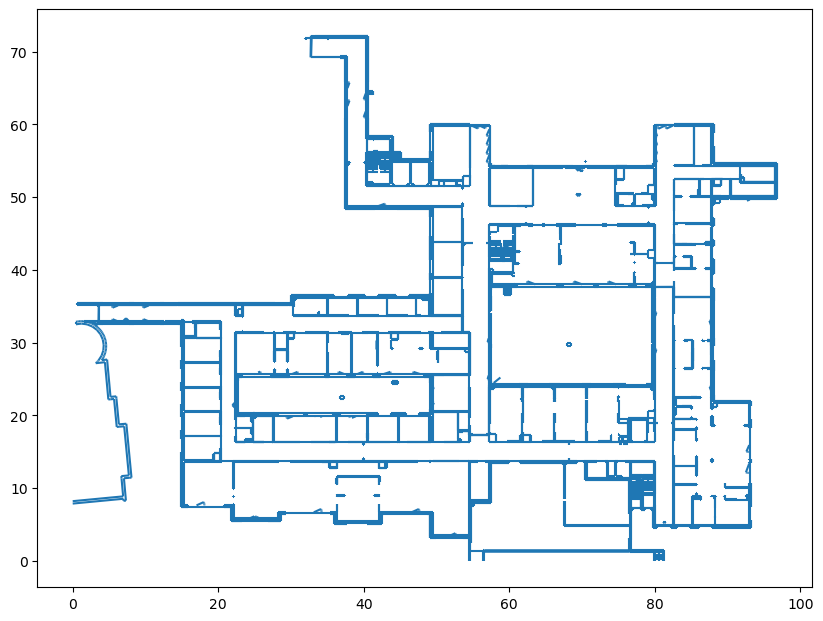

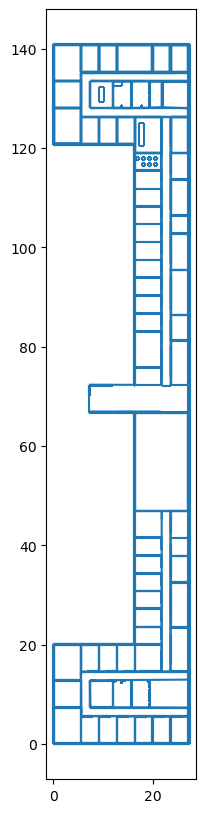

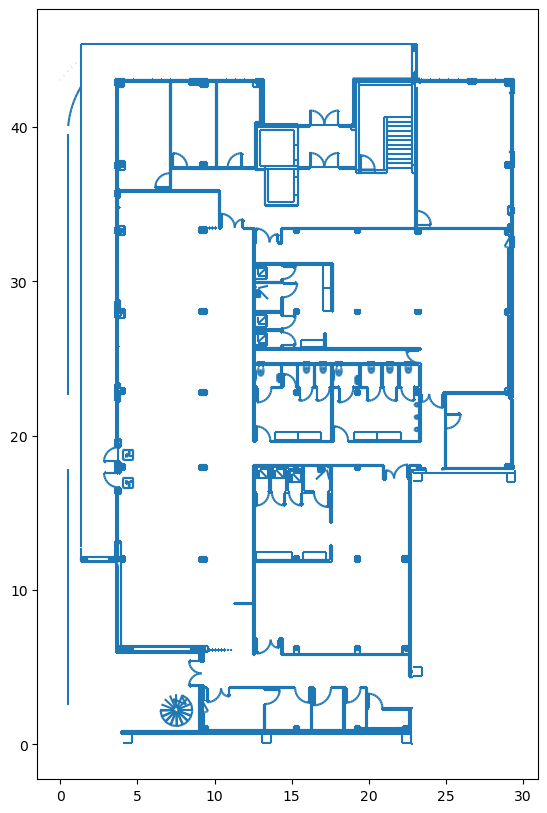

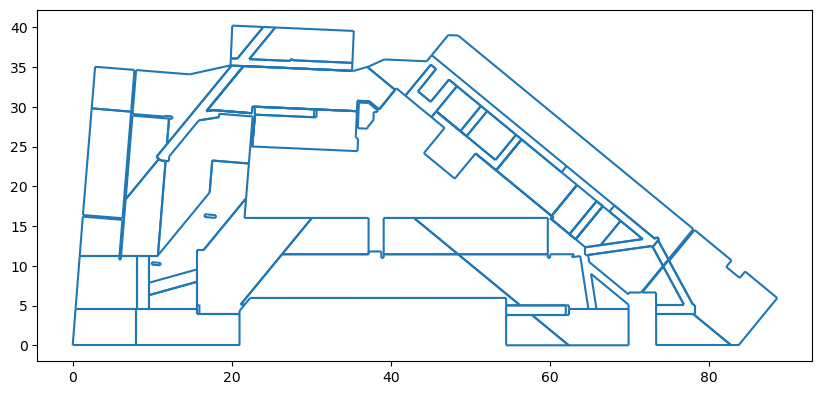

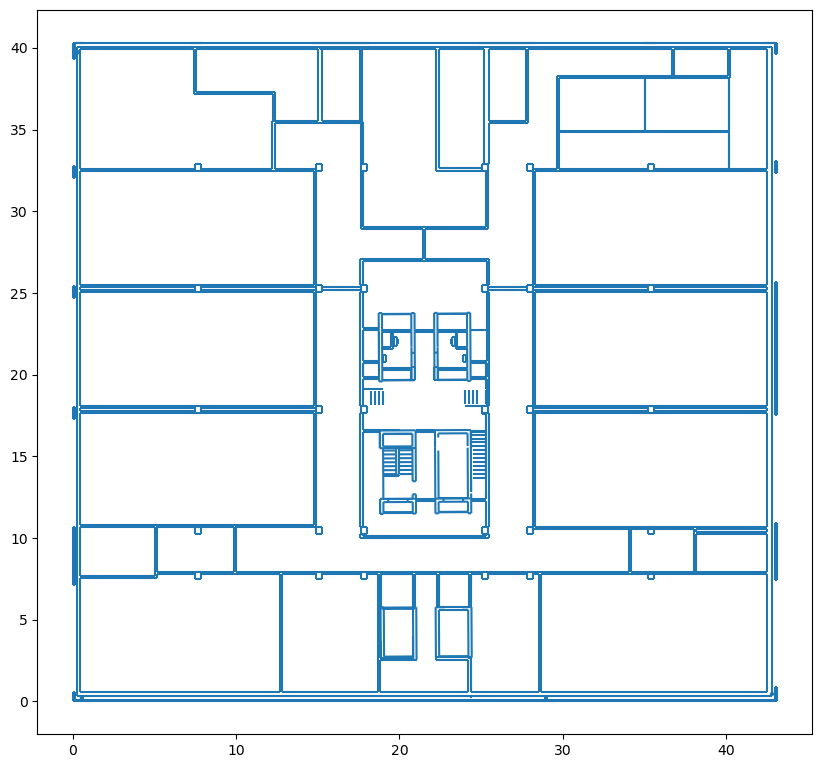

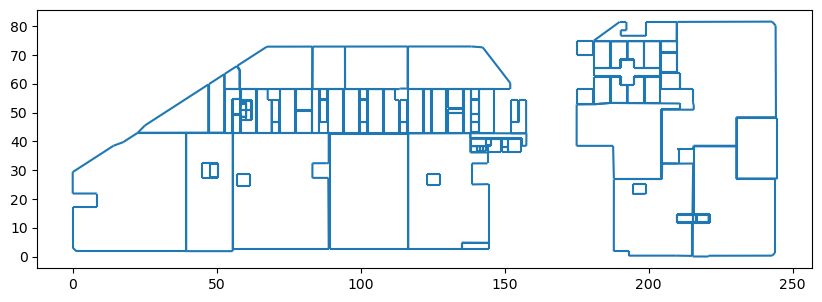

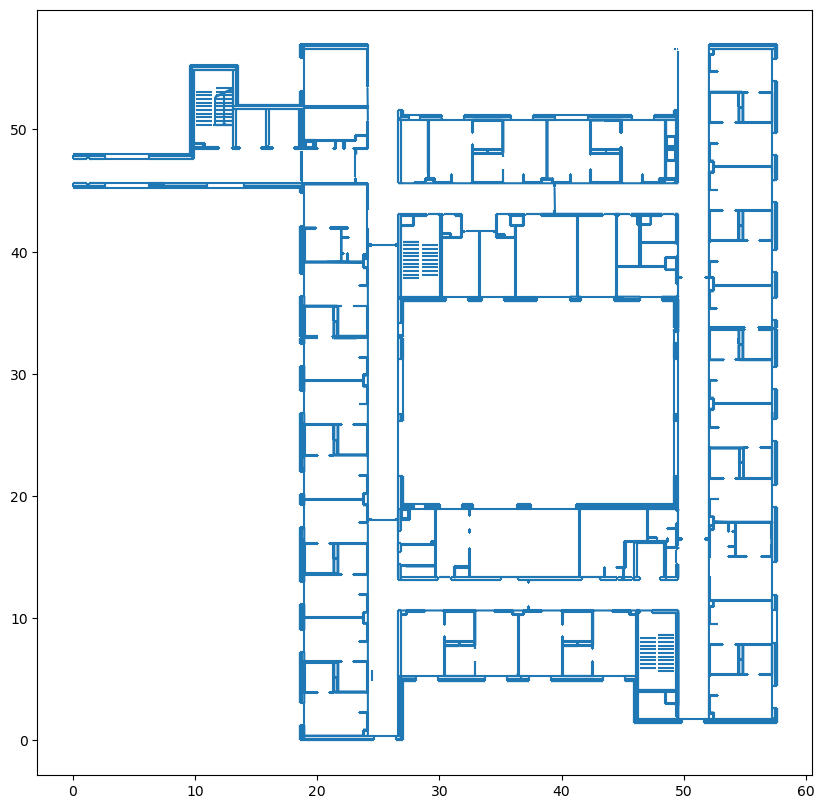

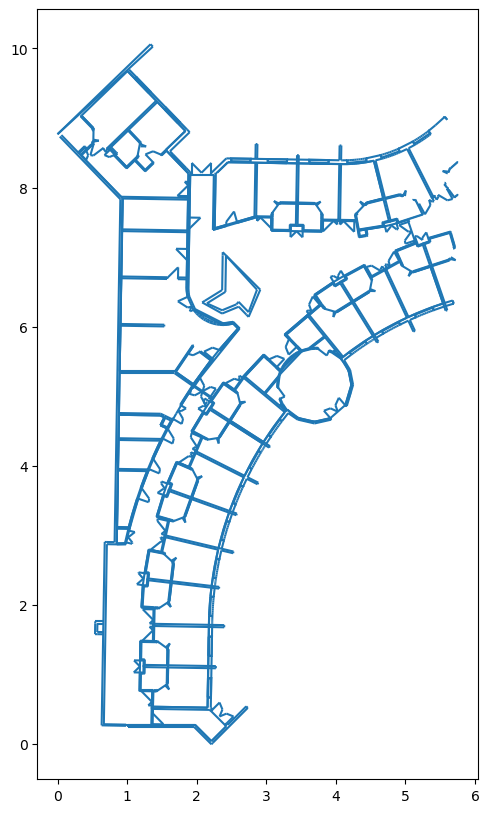

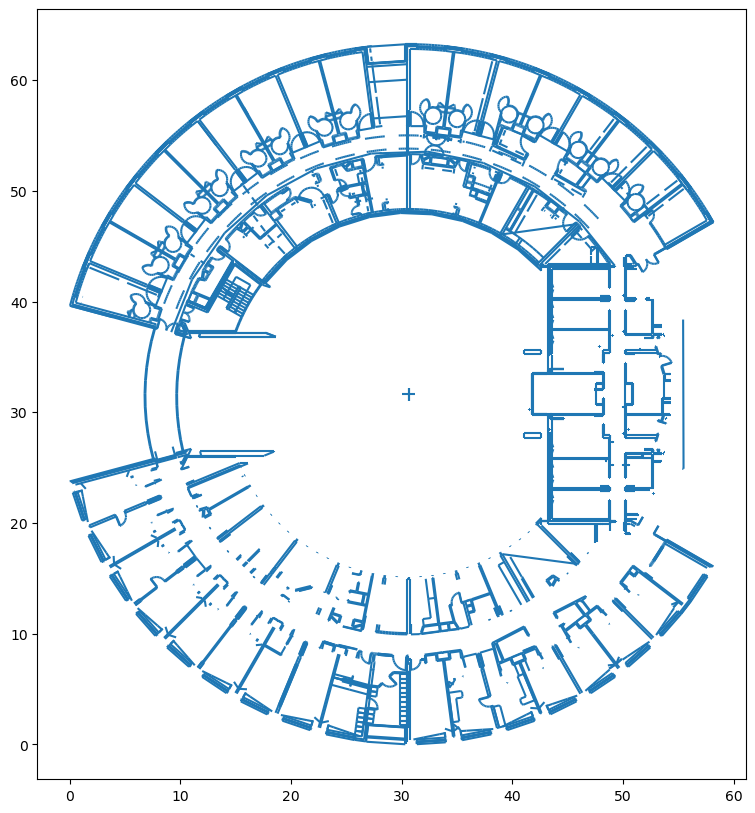

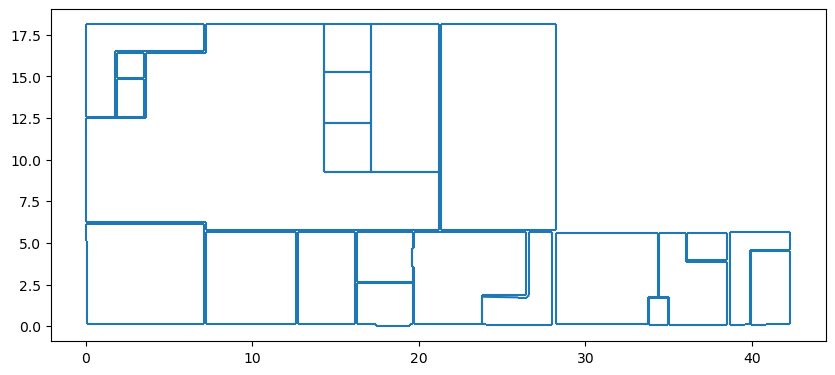

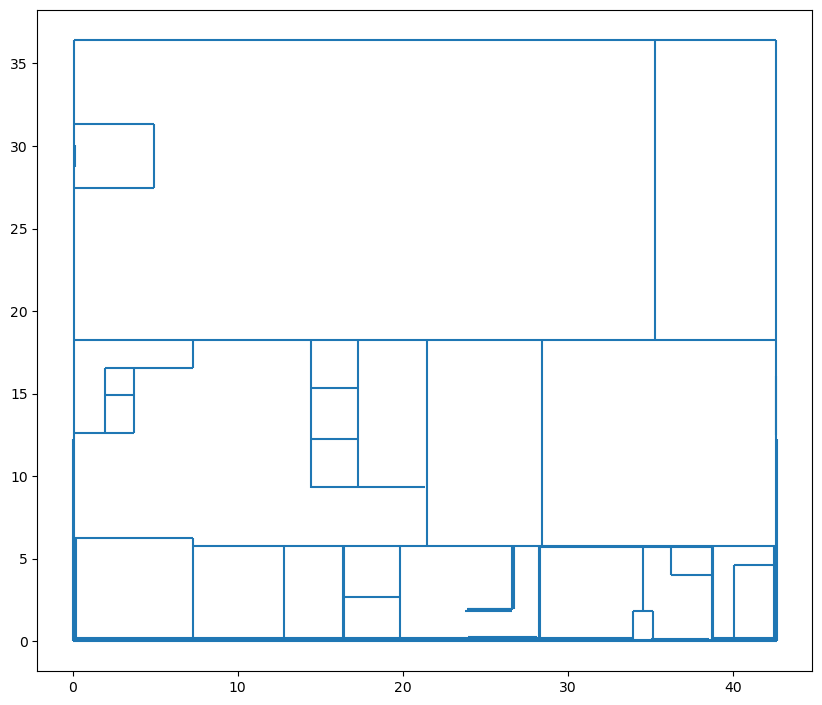

In [4]:
# Chargement des segments et affichage des plans
paths = []

for file_name in files_names:
    paths.append(processed_dir / f"{file_name}_clean.geojson")

# Load the segments
segments = []
transform_parameters = []
for i, path in enumerate(paths):
    segment, transform_parameter = pg.load_segments(path)
    segments.append(segment)
    transform_parameters.append(transform_parameter)
    print(f"Map number {i} has been loaded")
    print(f"   Saved parameters for inverse transformation are: {transform_parameter}")
    print(f"   Has loaded {len(segment.geoms)} segments, total {segment.length:.0f}m, mean length {segment.length/len(segment.geoms):.4f}m")

#Plot the segments
for i, segment in enumerate(segments):
    pg.plot_GeometryCollection(segment, figsize=(10, 10))

In [5]:
# Générations d'images png noir et blanc, traits épaissis, à partir des segments et sauvegarde des métadonnées de transformation

# Paramètres pour la génération des images
dpi_choice = 50  # Changer la résolution ici (ex: 30, 50, 100...)
thickness_choice = 1  # Épaisseur des lignes en pixels (impair de préférence)
scale = dpi_choice  # 1m = dpi_choice pixels

# Méthode de dilatation ('ellipse', 'cross', 'gaussian' 
# -> gaussien est plus efficace pour l'épaississement des traits obliques et courbes)
method_choice = 'gaussian'

# Génération des images avec le DPI et épaisseur des traits choisis
for i, segment, file_name in zip(range(len(segments)), segments, files_names):
    ccg.generate_binary_image(
        segment,
        transform_parameters[i],
        file_name,
        binary_images_dir,
        metadatas_dir,
        scale=scale,
        thickness=thickness_choice,
        method=method_choice
    )

Saved binary map: 02_binary_images/Output0_binary_image.png
Saved transform metadata: 03_metadatas/Output0_metadata.json

Saved binary map: 02_binary_images/Output1_binary_image.png
Saved transform metadata: 03_metadatas/Output1_metadata.json

Saved binary map: 02_binary_images/Output2_binary_image.png
Saved transform metadata: 03_metadatas/Output2_metadata.json

Saved binary map: 02_binary_images/Output3_binary_image.png
Saved transform metadata: 03_metadatas/Output3_metadata.json

Saved binary map: 02_binary_images/Output4_binary_image.png
Saved transform metadata: 03_metadatas/Output4_metadata.json

Saved binary map: 02_binary_images/Output5_binary_image.png
Saved transform metadata: 03_metadatas/Output5_metadata.json

Saved binary map: 02_binary_images/Output6_binary_image.png
Saved transform metadata: 03_metadatas/Output6_metadata.json

Saved binary map: 02_binary_images/Output7_binary_image.png
Saved transform metadata: 03_metadatas/Output7_metadata.json

Saved binary map: 02_bin

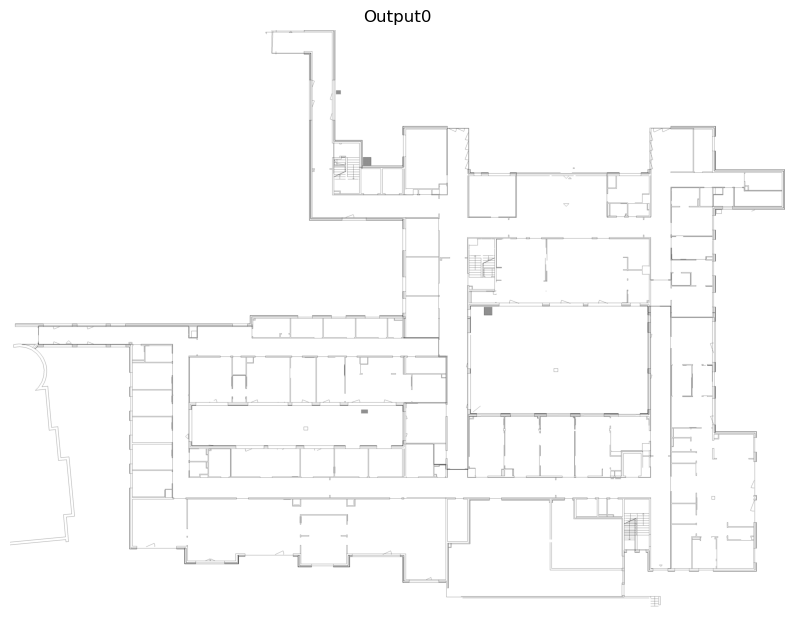

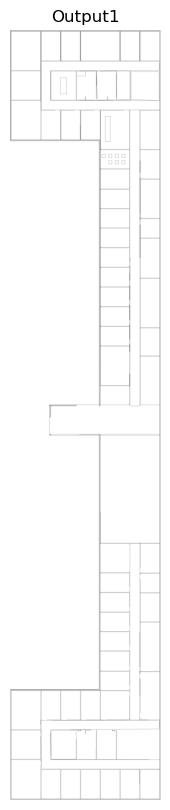

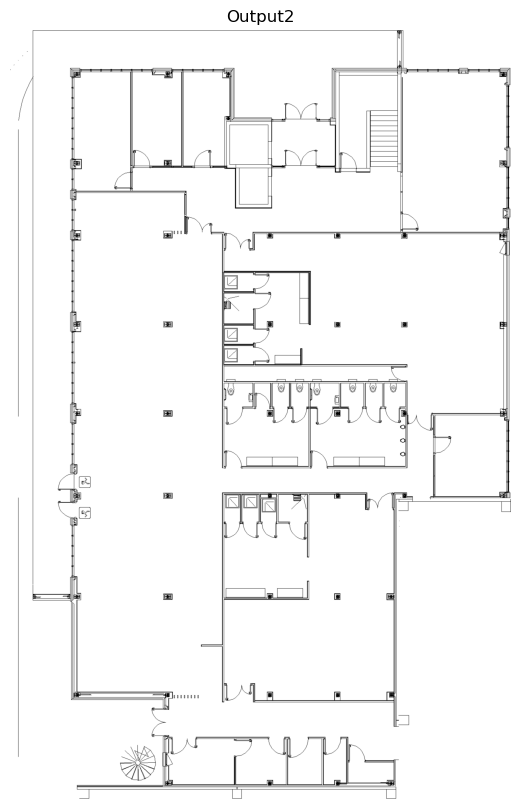

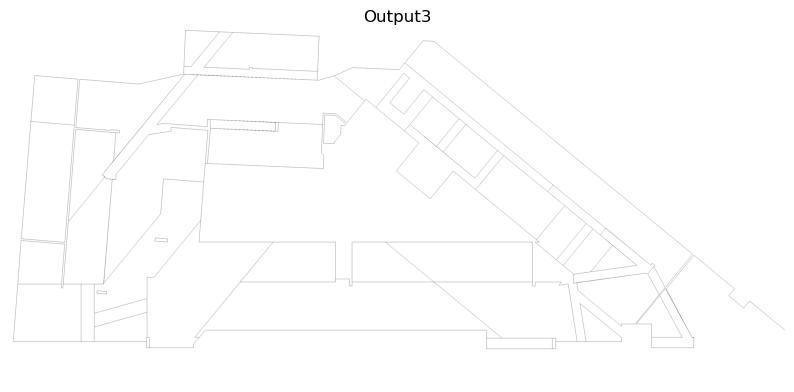

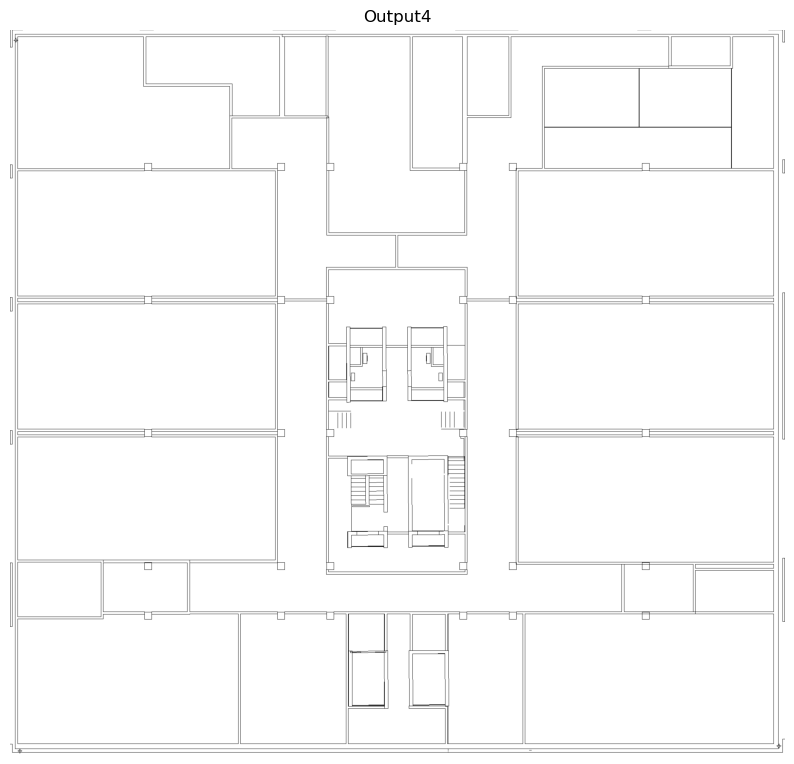

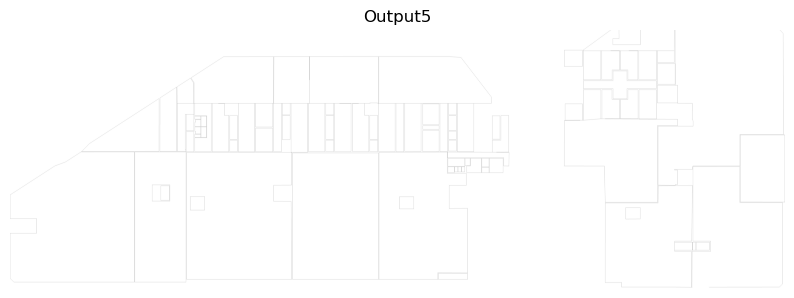

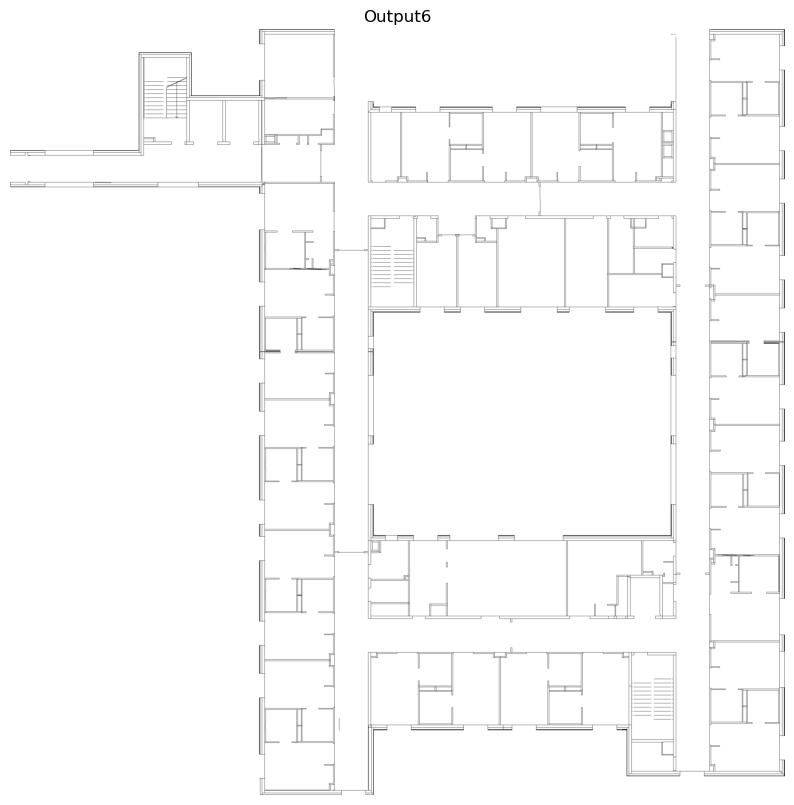

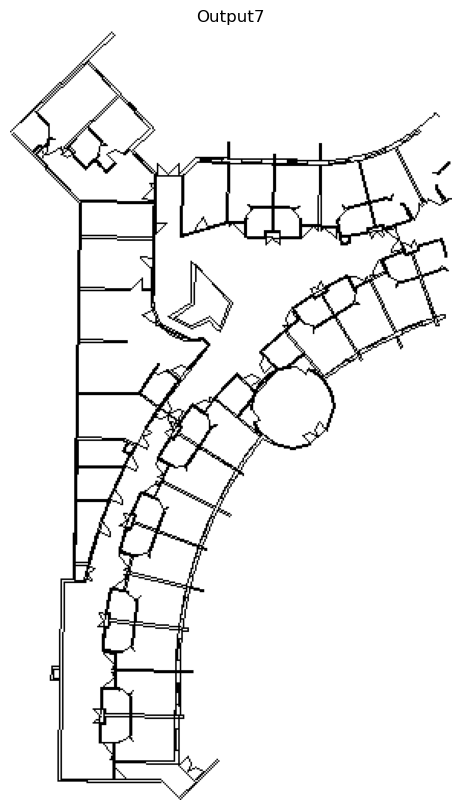

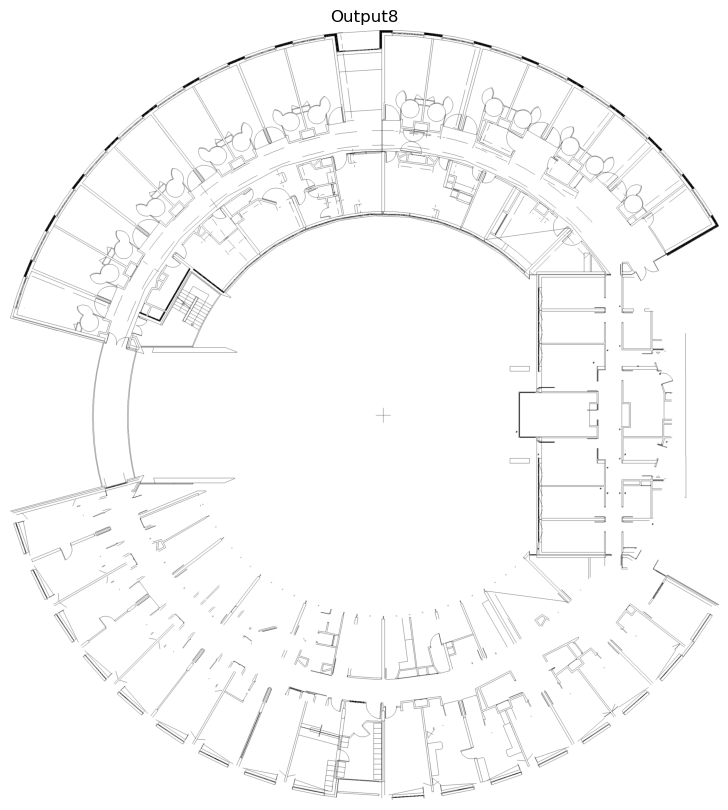

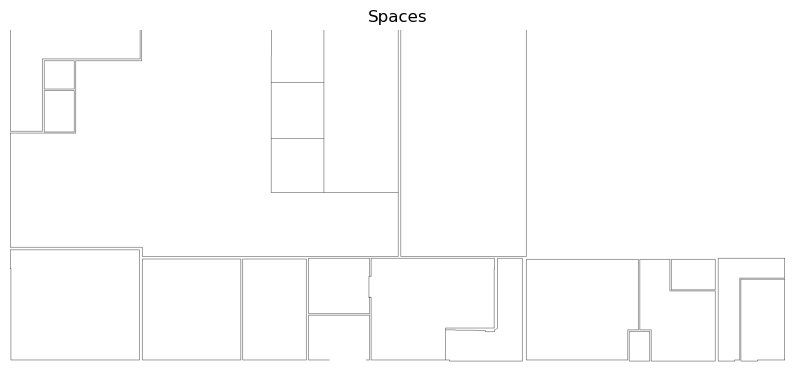

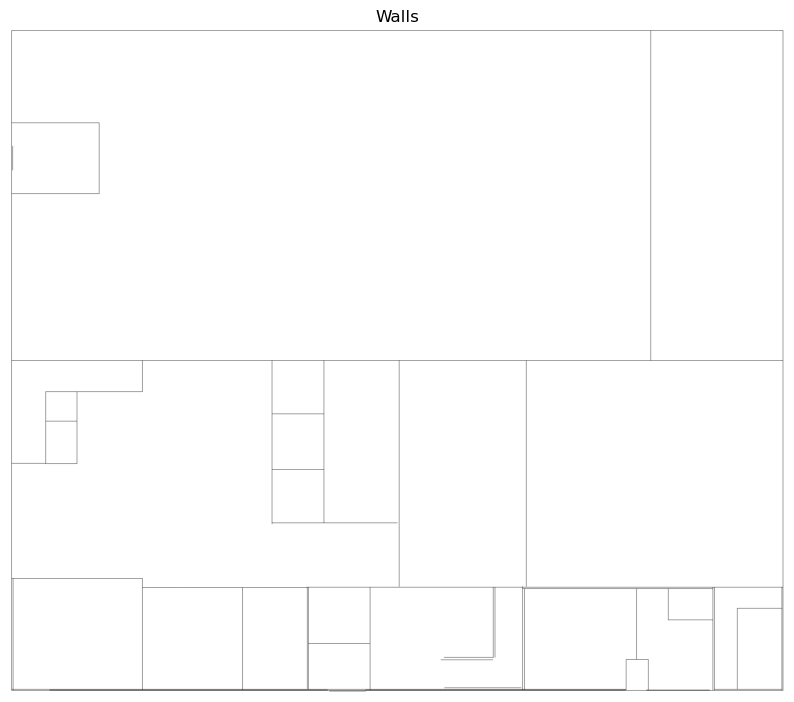

In [6]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = binary_images_dir / f"{file_name}_binary_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    plt.title(f"{file_name}")
    plt.show()

In [7]:
# Génération des pièces (image + geojson) à partir des images binaires et des métadonnées de transformation
import capstone_contours_generation as ccg

surface_minimale=1 # surface minimale en m²
surface_minimale_pixels = surface_minimale * (dpi_choice**2)  # Conversion en pixels
epaisseur_min_m=0.20
epsilon_ratio=0.1

for file_name in files_names:
    ccg.generer_pieces_image_et_geojson(
            file_name,
            binary_images_dir,
            metadatas_dir,
            contours_images_dir,
            rooms_contours_geojson_dir,
            surface_minimale=surface_minimale_pixels,
            dpi=dpi_choice,
            epaisseur_min_m=epaisseur_min_m, 
            epsilon_ratio=epsilon_ratio
    )

➡️ Suppression du contour le plus long : index 0, périmètre 30060.13px
✅ Restants après suppression périmètre : 101 / 102
ℹ️ Seuil d'épaisseur en pixels : 10.00px (équivalent à 0.2m)
❌ Contour 0 supprimé : épaisseur 4.83px < seuil 10.00px
❌ Contour 4 supprimé : épaisseur 4.87px < seuil 10.00px
❌ Contour 10 supprimé : épaisseur 4.96px < seuil 10.00px
❌ Contour 12 supprimé : épaisseur 4.94px < seuil 10.00px
❌ Contour 18 supprimé : épaisseur 8.99px < seuil 10.00px
❌ Contour 25 supprimé : épaisseur 4.85px < seuil 10.00px
❌ Contour 26 supprimé : épaisseur 8.67px < seuil 10.00px
❌ Contour 27 supprimé : épaisseur 8.62px < seuil 10.00px
❌ Contour 28 supprimé : épaisseur 8.62px < seuil 10.00px
❌ Contour 31 supprimé : épaisseur 4.91px < seuil 10.00px
❌ Contour 33 supprimé : épaisseur 4.88px < seuil 10.00px
❌ Contour 37 supprimé : épaisseur 7.87px < seuil 10.00px
❌ Contour 40 supprimé : épaisseur 9.41px < seuil 10.00px
❌ Contour 41 supprimé : épaisseur 9.30px < seuil 10.00px
❌ Contour 42 supprimé

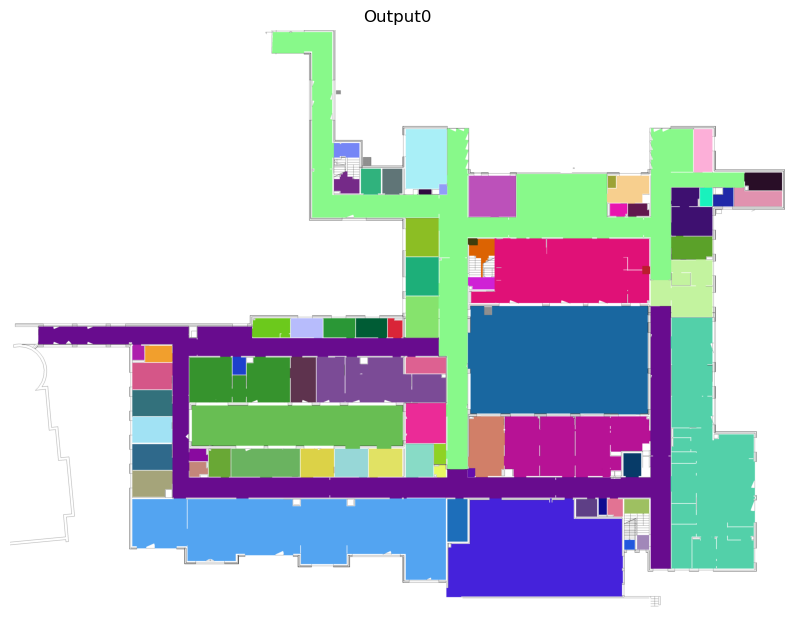

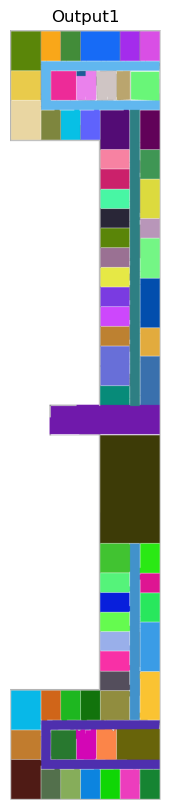

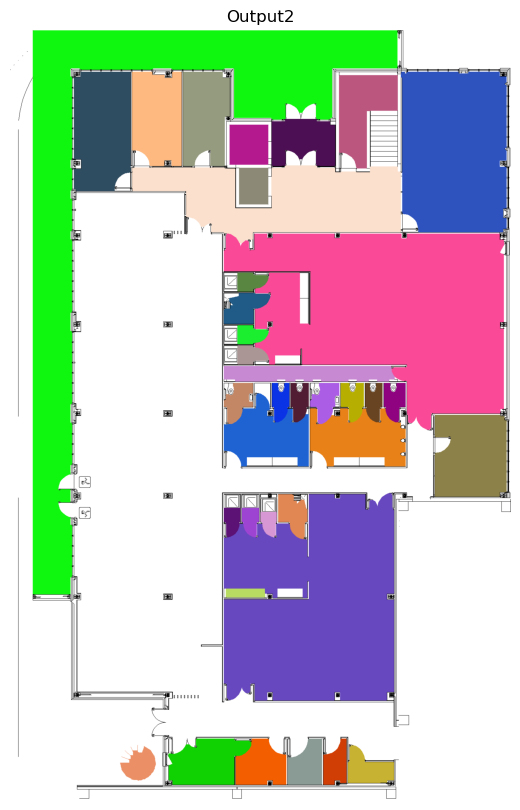

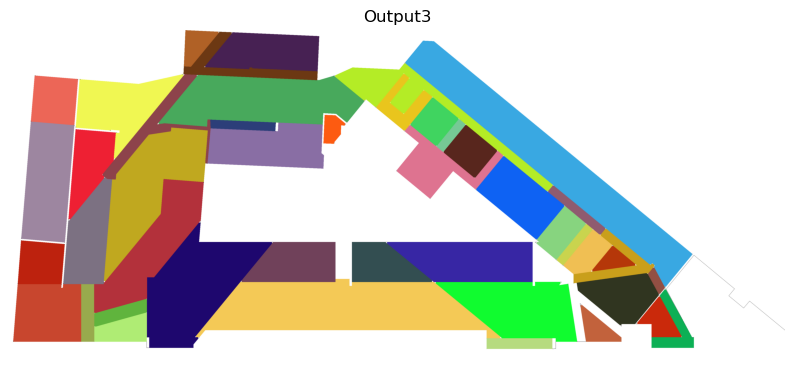

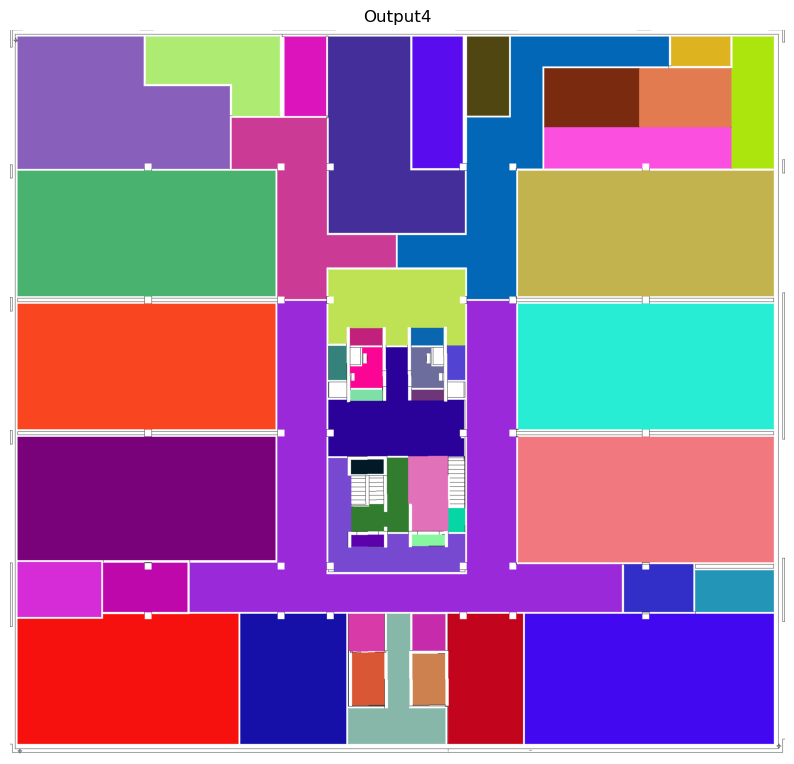

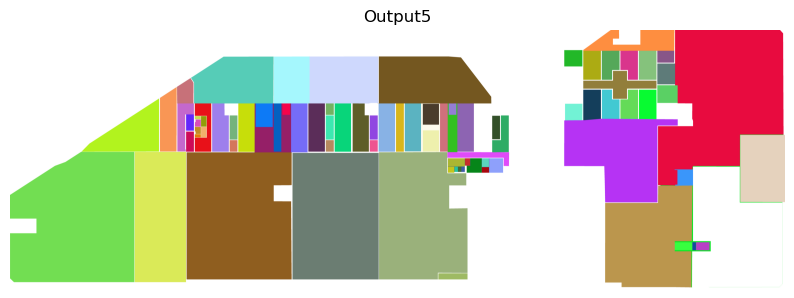

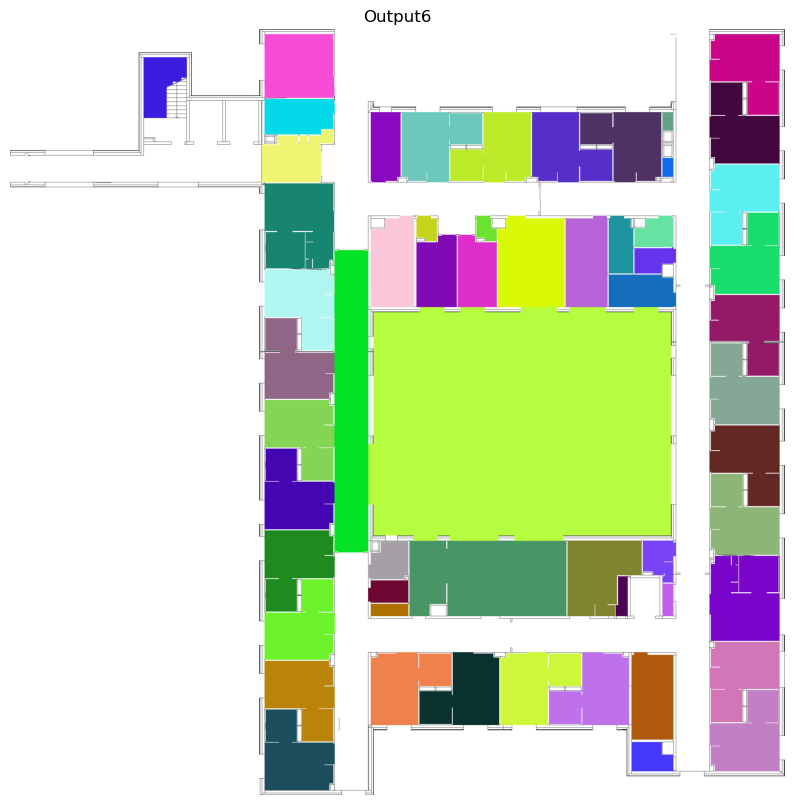

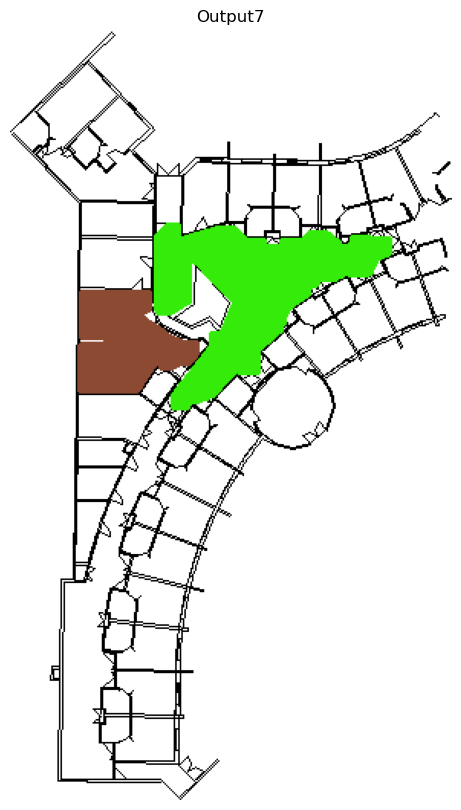

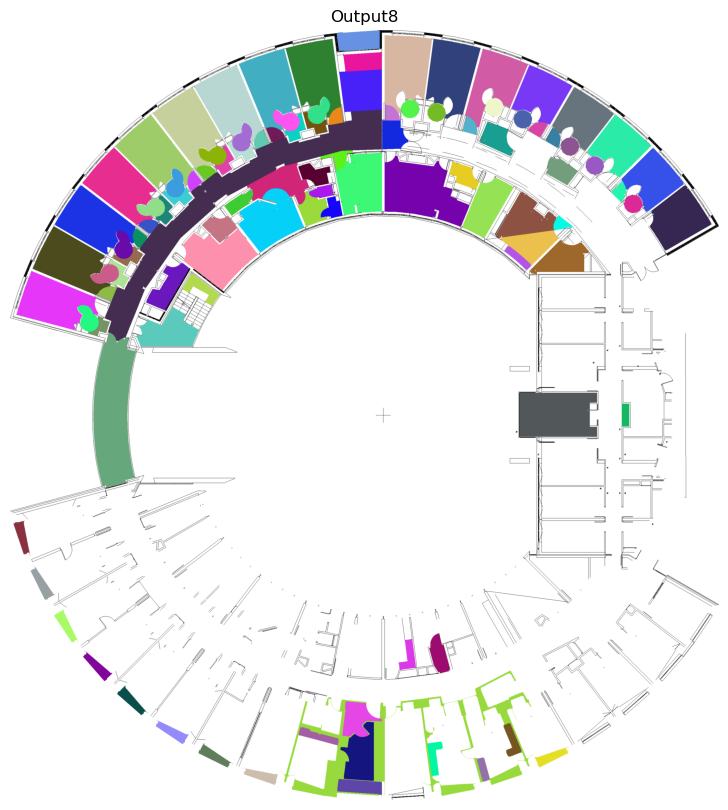

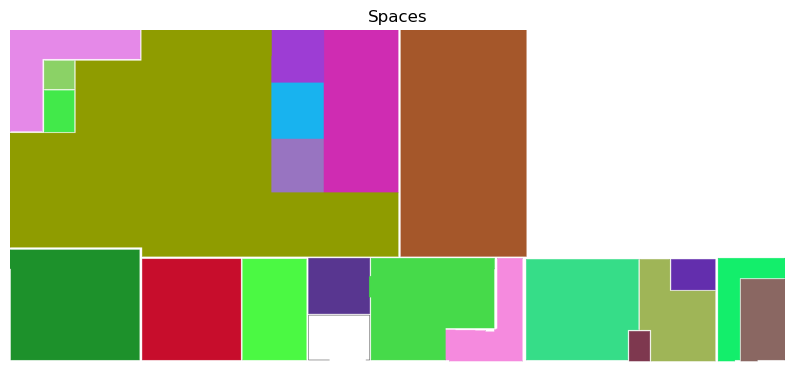

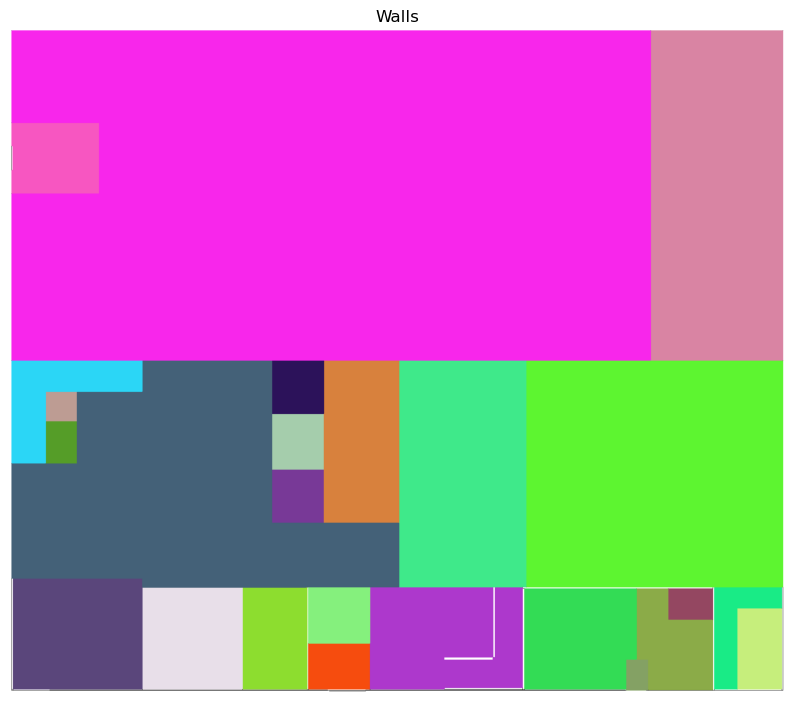

In [8]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = contours_images_dir / f"{file_name}_contours_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    plt.title(f"{file_name}")
    plt.show()

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/geopandas/plotting.py:684: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


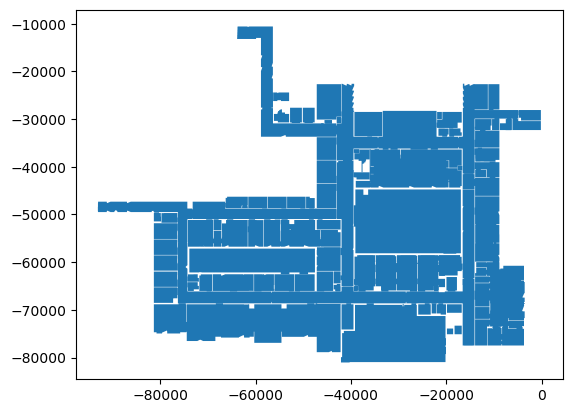

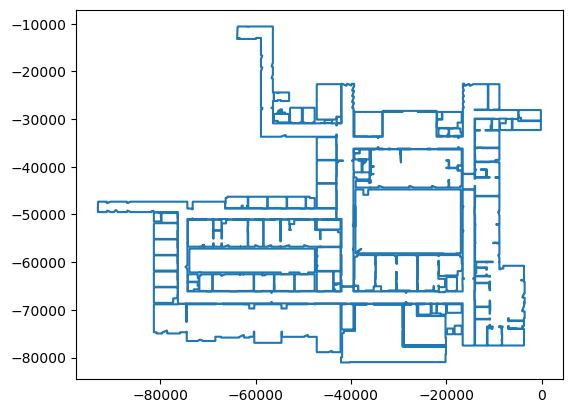

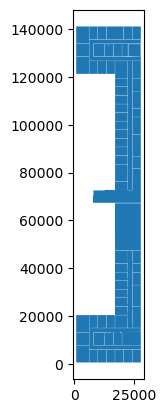

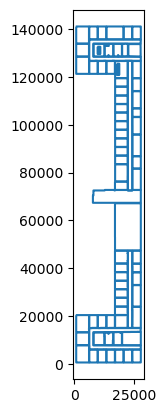

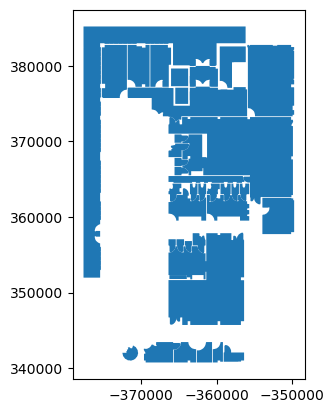

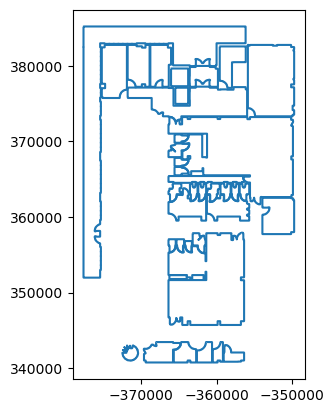

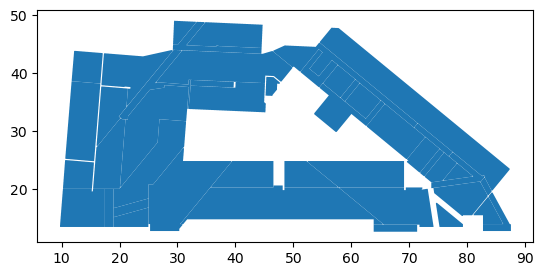

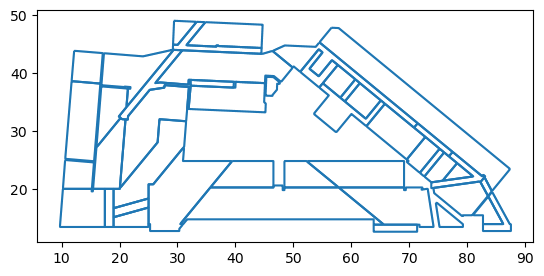

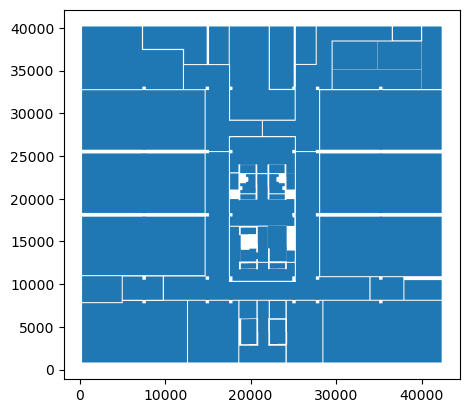

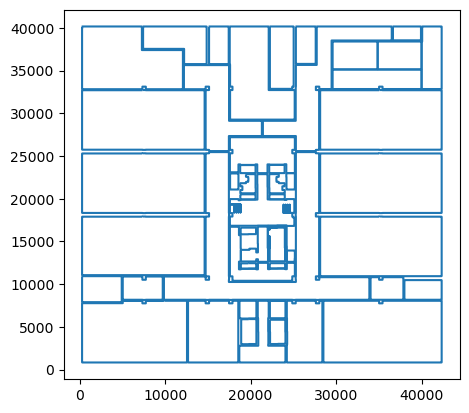

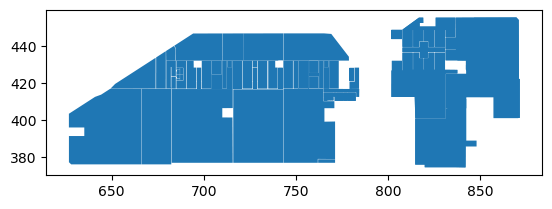

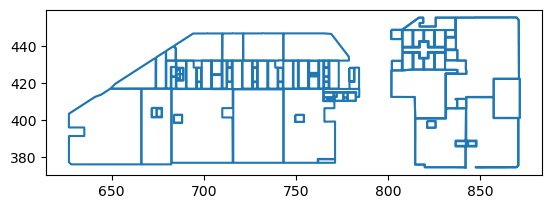

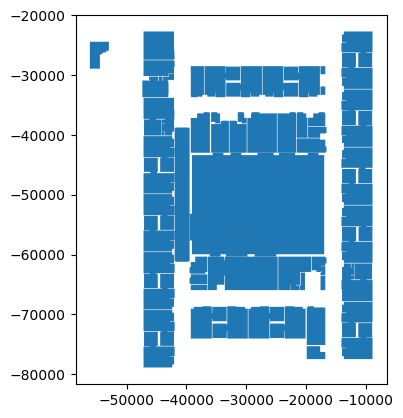

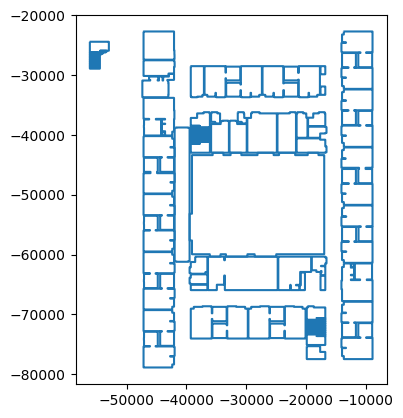

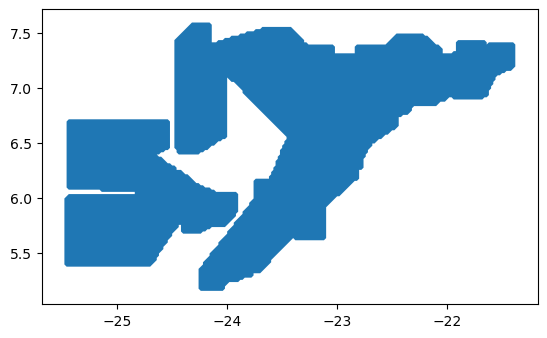

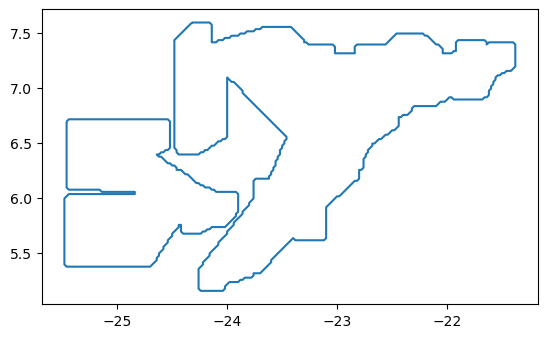

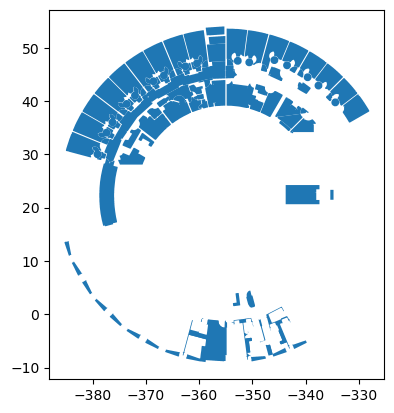

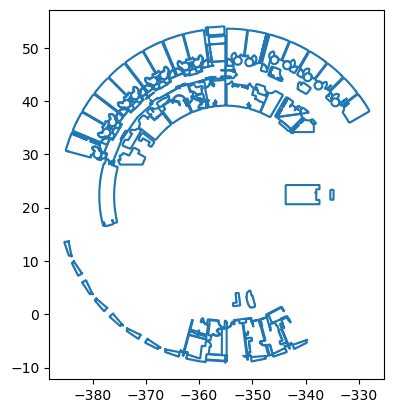

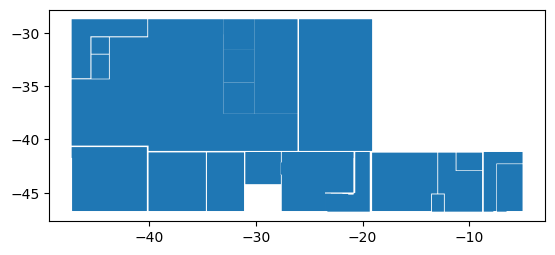

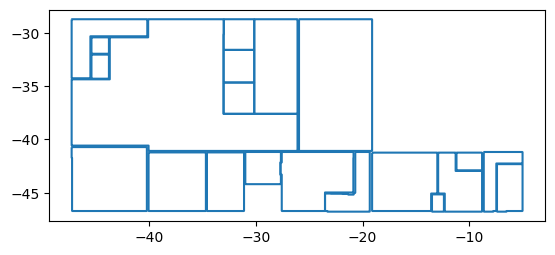

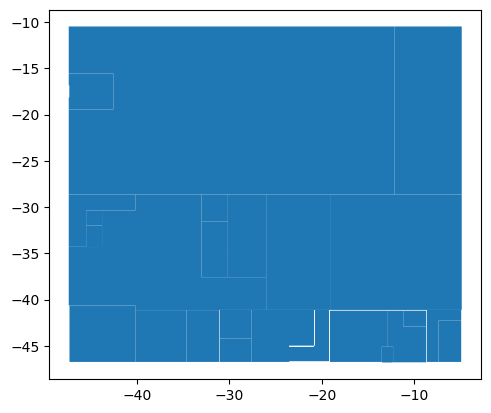

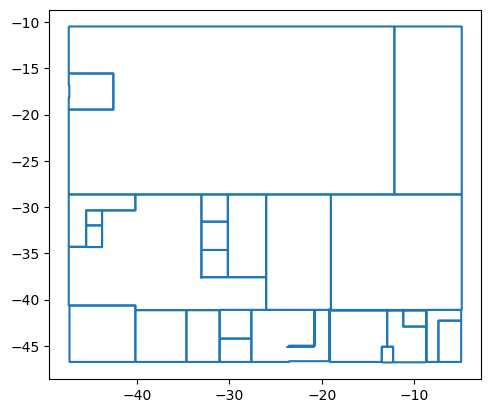

In [9]:
# Imprime les geojson : polygones & contours des pièces

for file_name in files_names:
    path = Path(rooms_contours_geojson_dir,f"{file_name}_rooms_contours.geojson")
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf.plot(aspect=1)
    gdf.boundary.plot(aspect=1)

In [15]:
import visualization_tools as vt

vt.create_ui_pipeline()